<a href="https://colab.research.google.com/github/Chintan2108/Cloud-Removal-in-Satellite-Images-using-Conditional-Generative-Adversarial-Networks/blob/master/Cloud_Removal_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cloud Removal in satellite images using GANs - an Image Restoration Approach**
---

## Step 1: Installing/Importing the required Python packages

- keras *(with tensorflow backend for Google Colab)*
- numpy
- matplotlib
- pandas
- os
- gdal
- re
- PIL
- tifffile

In [ ]:
!pip install tifffile

In [ ]:
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization       
from keras.layers import LeakyReLU
from copy import copy, deepcopy
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from matplotlib import pyplot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import re
import numpy as np
import pandas as pd
import gdal
import os
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
from IPython import display

- Creating a Google Colab upload utility to upload miscellaneous files

In [ ]:
from google.colab import files
files.upload()

- Setting the working directory, mounting gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
ROOT_PATH = 'gdrive/My Drive/Cloud Removal using GANs'

## Step 2: Writing generic functions to read data from BIL (Band Interleaved by Line) format

> 2.1 reading metadata for BIL format and writing function to read BIL image format

In [ ]:
#writing the function to read the BIL format image into a numpy array
def ReadBILFile(filepath, bands, pixels, dtype):
  '''
  This function reads an img file stored in the BIL format and reads an image
  It takes the filepath, number of bands, number of pixels, and the datatype of the DN values as args
  It reads a BIL image in the format: rows x cols = total_no_of_pixels x no_of_bands  
  '''
  image = np.zeros((pixels, bands), dtype)
  gdal.GetDriverByName('EHdr').Register()

  img = gdal.Open(filepath)
  for band_index in range(bands):
    bandx = img.GetRasterBand(band_index + 1)
    datax = bandx.ReadAsArray().reshape(pixels)
    for i in range(pixels):
      image[i][band_index] = datax[i]

  return image

In [ ]:
#reading metadata for BIL format unfolding
f1 = open(ROOT_PATH + '/data/True/3_20191027_subset.hdr','r')
data = f1.readlines()
metadata = {line.split(":")[0]:line.split(":")[1].split('\n')[0].strip() for line in data[:13]}

#extracting required metadata
bands  = int(metadata['BANDS'])
rows = int(metadata['ROWS'])
cols = int(metadata['COLS'])
dtype = 'uint' + metadata['DATATYPE'][1:]

FileNotFoundError: ignored

> 2.2 Reading BIL format True and False images (wrt GAN) using the above function

In [ ]:
true_img_filepath = ROOT_PATH + '/data/True/3_20191027_subset'
false_img_filepath = ROOT_PATH + '/data/False/3_20191030_subset'

#read clear/true image as train image and cloudy/false image as test image
train_img = ReadBILFile(true_img_filepath, bands, rows*cols, dtype)
test_img = ReadBILFile(false_img_filepath, bands, rows*cols, dtype)

In [ ]:
train_img.shape

(9006001, 3)

In [ ]:
test_img.shape

(9006001, 3)

## Step 3: Creating Train and Test data from the images read above

This step consists of creating, augmenting rather, the train and test data from single satellite images respectively, of the same location. The Train or TRUE image is the cloud-free image while the Test or FALSE image is a cloudy image. 

We augment more images out of both TRUE and FALSE images by performing operations such as rescaling and skewing along any one of the image axes to augment a dataset of 10 images stacked.



> 3.1   Rescaling the images within unity



In [ ]:
#preserving the original train and test variable buckets for validation
temp_train = train_img
temp_test = test_img

#resizing/normalizing the pixel values within unity
temp_train = temp_train/temp_train.max()
temp_test = temp_test/temp_test.max()

#re-normalizing to convert negative values into positive values
temp_train = (temp_train + 1)/2
temp_test = (temp_test + 1)/2

> 3.2   Reshaping the scaled images as per the row and col dimension of the original image

In [ ]:
temp_train = temp_train.reshape(rows, cols, 3)
temp_test = temp_test.reshape(rows, cols, 3)

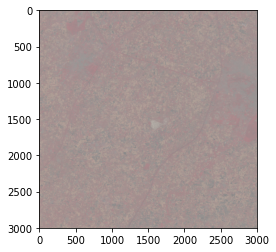

In [ ]:
plt.imshow(temp_train)

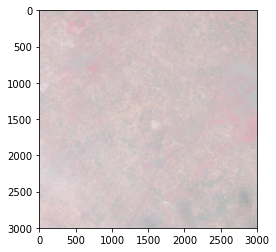

In [ ]:
plt.imshow(temp_test)

> 3.3   Slicing the image into 1024 x 1024 x 3 dimension

In [ ]:
temp_train = temp_train[:1024, :1024, :]
temp_test = temp_test[:1024, :1024, :]

In [ ]:
temp_train.shape

(1024, 1024, 3)

In [ ]:
temp_test[:,:,:0].shape

(1024, 1024, 0)

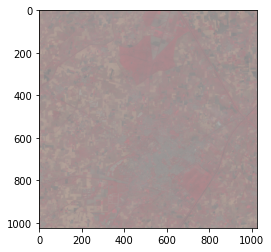

In [ ]:
plt.imshow(temp_train)

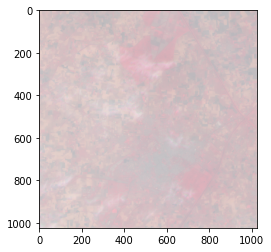

In [ ]:
plt.imshow(temp_test)

> 3.4   Skewing the TRUE image to augment training set

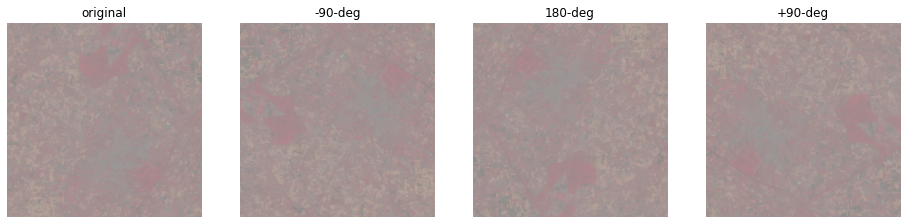

In [ ]:
#----------training stack-------------#
tem1 = deepcopy(temp_train)
# -------- MY NEW APPROACH -----------------#
# #no skew
# tem3 = deepcopy(temp_train)

# #90 deg clockwise
# tem4 = deepcopy(temp_train)
# tem4 = np.rot90(tem4, axes=(1,0))

# #90 deg anti-clockwise
# tem5 = deepcopy(temp_train)
# tem5 = np.rot90(tem5, axes=(0,1))

# #180 deg 
# #rotate 180 deg clockwise/anti-clockwise
# tem6 = deepcopy(temp_train)
# tem6 = np.rot90(tem6, axes=(1,0))
# tem6 = np.rot90(tem6, axes=(1,0))
# ------------------------------------------#

# ---------- REFERENCE CODE APPROACH --------#
tem3=np.rot90(tem1)
tem4=np.rot90(tem1, 2)
tem5=np.rot90(tem1, 3)
# -------------------------------------------#

#displaying the distinct images of the training stack
fig, a = plt.subplots(1,4, figsize=(16,4))

a[0].imshow(tem1)
a[0].set_title('original')
a[0].axis('off')

a[1].imshow(tem3)
a[1].set_title('-90-deg')
a[1].axis('off')

a[2].imshow(tem4)
a[2].set_title('180-deg')
a[2].axis('off')

a[3].imshow(tem5)
a[3].set_title('+90-deg')
a[3].axis('off')

plt.show()

In [ ]:
#stacking the augmented TRUE images
train_stack = np.stack((tem3, tem4, tem5, tem3, tem4, tem5, tem3, tem4, tem5, tem3), axis=0)
print(train_stack.shape)

#saving the training set on disk
np.save(ROOT_PATH + '/data/train_data_3_10copy', train_stack)

(10, 1024, 1024, 3)


> 3.5   Skewing the FALSE image to augment testing set

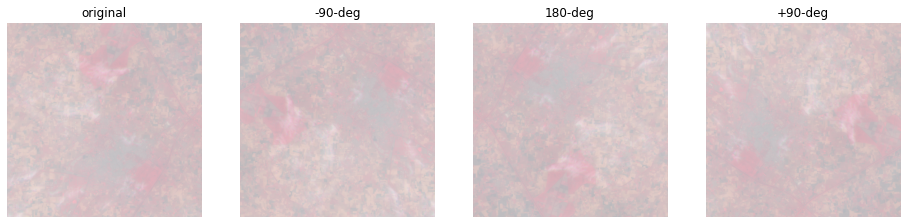

In [ ]:
#----------testing stack-------------#
tem2 = deepcopy(temp_test)
# # -------- MY NEW APPROACH -----------------#
# #no skew
# tem7 = deepcopy(temp_test)

# #90 deg clockwise
# tem8 = deepcopy(temp_test)
# tem8 = np.rot90(tem8, axes=(1,0))

# #90 deg anti-clockwise
# tem9 = deepcopy(temp_test)
# tem9 = np.rot90(tem9, axes=(0,1))

# #180 deg 
# #rotate 180 deg clockwise/anti-clockwise
# tem10 = deepcopy(temp_test)
# tem10 = np.rot90(tem10, axes=(1,0))
# tem10 = np.rot90(tem10, axes=(1,0))
# # ------------------------------------------#

# ---------- REFERENCE CODE APPROACH --------#
tem6=np.rot90(tem2)
tem7=np.rot90(tem2, 2)
tem8=np.rot90(tem2, 3)
# -------------------------------------------#

#displaying the distinct images of the training stack
fig, a = plt.subplots(1,4, figsize=(16,4))


a[0].imshow(tem2)
a[0].set_title('original')
a[0].axis('off')

a[1].imshow(tem6)
a[1].set_title('-90-deg')
a[1].axis('off')

a[2].imshow(tem7)
a[2].set_title('180-deg')
a[2].axis('off')

a[3].imshow(tem8)
a[3].set_title('+90-deg')
a[3].axis('off')

plt.show()

In [ ]:
#stacking the augmented FALSE images
train_stack = np.stack((tem6, tem7, tem8, tem6, tem7, tem8, tem6, tem7, tem8, tem6), axis=0)
print(train_stack.shape)

#saving the testing set on disk
np.save(ROOT_PATH + '/data/test_data_3_10copy', train_stack)

(10, 1024, 1024, 3)


## Loading train and test datasets from disk

In [ ]:
import numpy as np

#loading test data
# src_data = np.load(ROOT_PATH + '/data/test_data_3_10copy.npy')
src_data = np.load(ROOT_PATH + '/data/test_data_4_10copy.npy')

#loading train data
# tar_data = np.load(ROOT_PATH + '/data/train_data_3_10copy.npy')
tar_data = np.load(ROOT_PATH + '/data/train_data_4_10copy.npy')

print("Train data shape: ", src_data.shape)
print("Test data shape: ", tar_data.shape)

Train data shape:  (10, 1024, 1024, 3)
Test data shape:  (10, 1024, 1024, 3)


##Step 4: Coding the pix2pix GAN model Architecture

This step consists of coding the architecture of the proposed GAN model. This will be done in three parts - implementing the discriminator, implementing the generator and linking the two (creating the GAN).

> 4.1.   Implementing the Discriminator Model

In [ ]:
#Discriminator Model

def define_discriminator(image_shape):
  '''
  This function portrays the discriminator model based on the image dimensions
  args --> image_shape: (x,y) for 2d; (x,y,d) for 3d
  '''
  init = RandomNormal(stddev=0.02)
  in_src_image = Input(shape=image_shape)
  # target image input
  in_target_image = Input(shape=image_shape)

  merged = Concatenate()([in_src_image, in_target_image])

  # C64
  d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)

  # C128
  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  # C256
  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  
  # C512
  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)
  d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  # patch output
  d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)
  
  # define model
  model = Model([in_src_image, in_target_image], patch_out)
  
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
  
  return model

>> 4.1.1 Implementing Encoder Block Architecture




In [ ]:
#ENCODER BLOCK

def define_encoder_block(layer_in, n_filters, batchnorm=True):
  '''
  This function protrays the architecture of an encoder block
  '''
  # weight initialization
  init = RandomNormal(stddev=0.02)

  #add downsampling layer
  g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)  	# add downsampling layer

  # conditionally add batch normalization
  if batchnorm:
    g = BatchNormalization()(g, training=True)

  #Activating Leaky RelU
  g = LeakyReLU(alpha=0.2)(g) 	
  return g

>> 4.1.2 Implementing Decoder Block Architecture

In [ ]:
# DECODER BLOCK

def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  '''
  This function portrays the architecture of a decoder block
  '''
  #weight initialization
  init = RandomNormal(stddev=0.02)

  #add upsampling layer
  g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in) 

  #add batch normalization
  g = BatchNormalization()(g, training=True)  	

  # conditionally add dropout
  if dropout:
    g = Dropout(0.5)(g, training=True)
    
  # merge with skip connection
  #basically we concatenate the layers produced by (upconvolution) and the original layer in encoder block
  g = Concatenate()([g, skip_in]) 

  # relu activation
  g = Activation('relu')(g)
  return g

> 4.2.   Implementing the Generator Model

In [ ]:
#Generator Model

def define_generator(image_shape=(256,256,3)):
  '''
  This function portrays the generator model based on the image dimensions
  args --> image_shape: (x,y) for 2d; (x,y,d) for 3d
  '''
  # weight initialization
  init = RandomNormal(stddev=0.02)

  # image input
  in_image = Input(shape=image_shape)
  
  # encoder model
  e1 = define_encoder_block(in_image, 64, batchnorm=False)
  e2 = define_encoder_block(e1, 128)
  e3 = define_encoder_block(e2, 256)
  e4 = define_encoder_block(e3, 512)
  e5 = define_encoder_block(e4, 512)
  e6 = define_encoder_block(e5, 512)
  e7 = define_encoder_block(e6, 512)
  
  # bottleneck, no batch norm and relu
  b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
  b = Activation('relu')(b)
  
  # decoder model
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)
  
  # output
  g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
  out_image = Activation('tanh')(g)
  
  # define model
  model = Model(in_image, out_image)
  
  return model

> 4.3   Combining the Discriminator and Generator model to form the GAN

In [ ]:
# Combine generator and Discriminator Model
def define_gan(g_model, d_model, image_shape):
  '''
  This function portrays the proposed GAN architecture
  args--> generator model, discriminator model, image shape 
  '''
  # make weights in the discriminator not trainable
  d_model.trainable = False
  
  # define the source image
  in_src = Input(shape=image_shape)
  
  # connect the source image to the generator input
  gen_out = g_model(in_src)
  
  # connect the source input and generator output to the discriminator input
  dis_out = d_model([in_src, gen_out])
  
  # src image as input, generated image and classification output
  model = Model(in_src, [dis_out, gen_out])
  
  # compile model
  opt = Adam(lr=0.00002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
  
  return model

##Step 5: Coding Some Utility Functions

This step includes coding some utility functions to select and generate batch of random samples, summarize model performance and train the model.

> 5.1   Selecting and Generating Batch of Samples

>> 5.1.2 Function to Generate Real Samples

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
  '''
  This functions selects a batch of random samples and returns an image with its target
  args --> image_stack, number of samples, patch shape
  '''
  # unpack dataset
  trainA, trainB = dataset
  
  # choose random instances
  ix = randint(0, trainA.shape[0], n_samples)
  
  # retrieve selected images
  X1, X2 = trainA[ix], trainB[ix]
  
  # generate 'real' class labels (1)
  y = ones((n_samples, patch_shape, patch_shape, 1))
  
  return [X1, X2], y

>> 5.1.2 Function to Generate Fake Samples

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
  '''
  This function uses the generator model to generate fake samples 
  args --> generator model, number of samples, patch shape
  '''
  # generate fake instance
  X = g_model.predict(samples)
  # create 'fake' class labels (0)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

> 5.2 Generating Samples and Model Epoch Utility Functions

In [ ]:
#Epoch operations to summarize model performance

def summarize_performance(step, g_model, dataset, n_samples=3):
  '''
  This function generates sample to pass on to the GAN, and creates the plot at 100X epochs with the src, tar and generated image
  args --> epoch step, generator model, dataset, number of samples
  '''
  # select a sample of input images
  [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
  
  # generate a batch of fake samples
  X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
  
  # scale all pixels from [-1,1] to [0,1]
  X_realA = (X_realA + 1) / 2.0
  X_realB = (X_realB + 1) / 2.0
  X_fakeB = (X_fakeB + 1) / 2.0
  
  # plot real source images
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realA[i])
  
  # plot generated target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_fakeB[i])
  
  # plot real target image
  for i in range(n_samples):
    pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
    pyplot.axis('off')
    pyplot.imshow(X_realB[i])
  
  # save plot to file
  filename1 = 'plot_%06d.png' % (step+1)
  pyplot.savefig(filename1)
  pyplot.close()
  
  # save the generator model
  filename2 = 'model_%06d.h5' % (step+1)
  g_model.save(filename2)
  print('>Saved: %s and %s' % (filename1, filename2))

> 5.3 Function to Train the Model

In [ ]:
def train(d_model, g_model, gan_model, dataset, n_epochs=200, n_batch=1):
  '''
  This function is for training the model based on the pixel-to-pixel architecture to achieve image to image tramslation using GAM
  args --> discriminator model, generator model, GAN model, train/test set, number of epochs, number of train batches/batch size
  '''
  # determine the output square shape of the discriminator
  n_patch = d_model.output_shape[1]
  
  # unpack dataset
  trainA, trainB = dataset
  
  # calculate the number of batches per training epoch
  bat_per_epo = int(len(trainA) / n_batch)
  
  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  
  #log all losses
  d_loss1_log = []
  d_loss2_log = []
  g_loss_log = []

  # manually enumerate epochs
  for i in range(n_steps):
    # select a batch of real samples
    [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
    
    # generate a batch of fake samples
    X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
    
    # update discriminator for real samples
    d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
    d_loss1_log.append(d_loss1)
    
    # update discriminator for generated samples
    d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
    d_loss2_log.append(d_loss2)
    
    # update the generator
    g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
    g_loss_log.append(g_loss)
    
    # summarize performance - plot loss per epoch
    
    plt.clf()
    plt.figure(figsize=(20,12))
    plt.title('Epoch:%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.plot(d_loss1_log, 'r-', lw=2, label='d_loss1')
    plt.plot(d_loss2_log, 'b-', lw=1, label='d_loss2')
    plt.plot(g_loss_log, 'g-', lw=1, label='g_loss')
    plt.legend(prop={'size':16}, loc="top right")
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
    
    # summarize model performance
    if (i+1) % (bat_per_epo * 10) == 0:
      plt.savefig('./loss_graph_%06d.jpg' % (i+1), bbox_inches='tight')
      summarize_performance(i, g_model, dataset)

##Step 6: Training the Model

In this step, we train the model for predef number of epochs and save the model to disk so that it can later be loaded to generate the images as well as for testing purpose. 

> 6.1 Training the Model - This will train the model and save the model at each 100 epochs on disk.

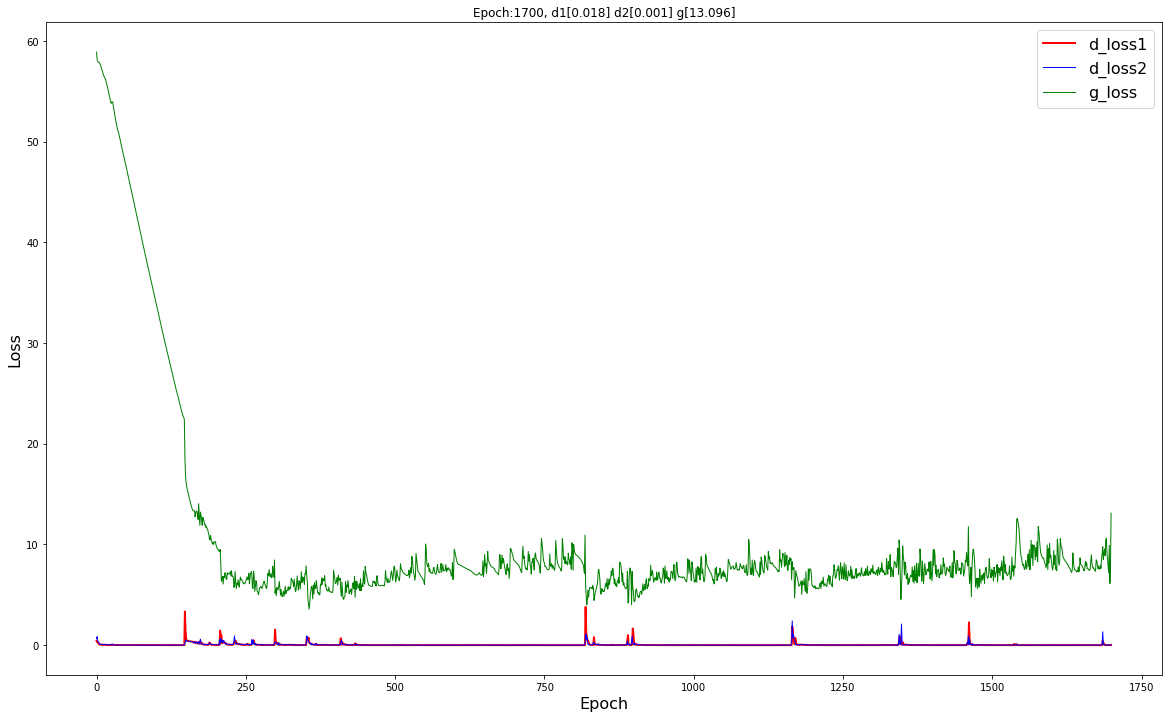

>1700, d1[0.018] d2[0.001] g[13.096]


In [ ]:
#Training Model

dataset=(src_data,tar_data)
print('loaded - ', src_data.shape, tar_data.shape)

# define input shape based on the loaded dataset
image_shape=src_data.shape[1:]

# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)

# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

# train model
train(d_model, g_model, gan_model, dataset, n_epochs=200)

##Step 7: Predicting the Cloud Free Image

In the previouos step, we have trained the model for predef number of epochs and predrf batch size. The model at each 100 epoch has been saved on the disk. From this point on, we can choose not to execute the previous steps as we now hace the option of loding the model straight from the disk and making the prediction. 

> 7.1 Importing packages to have seperate implementation from this step

In [ ]:
from keras.models import load_model
from numpy import load
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
import os

> 7.2 Utility functions 

>> 7.2.1 Function to load and prepare the training images

In [ ]:
# load and prepare training images
def load_real_samples(filename):
  '''
  This function reads the stacked array dataset and returns the TRUE and FALSE images in a single list
  args --> filename/ file location (abs path | rel path)
  '''
  # load compressed arrays
  #data = load(filename)
  # unpack arrays
  #X1, X2 = data['arr_0'], data['arr_1']
  X1=data1
  X2=data2
  # scale from [0,255] to [-1,1]
  #X1 = (X1 - 127.5) / 127.5
  #X2 = (X2 - 127.5) / 127.5
  X1=X1.astype('uint16')
  X2=X2.astype('uint16')
  return [X1, X2]

>> 7.2.2 Function to plot the source, generated and expected image

In [ ]:
#Plot Images
def plot_images(src_img, gen_img, tar_img):
  '''
  This function plots the three images in a matplot
  '''
  images = vstack((src_img, gen_img, tar_img))
  
  # scale from [-1,1] to [0,1]
  images = (images + 1) / 2.0
  
  titles = ['Source', 'Generated', 'Expected']
  
  #drawing the plot
  fig, a = plt.subplots(1,3, figsize=(16,4))

  # plot images row by row in subplot
  for i in range(len(images)):
    # show image
    a[i].imshow(images[i])

    # set title
    a[i].set_title(titles[i])

    # turn off axis
    a[i].axis('off')
  plt.show()

> 7.3 Predicting Images using the model(s)

Loaded (10, 1024, 1024, 3) (10, 1024, 1024, 3)


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


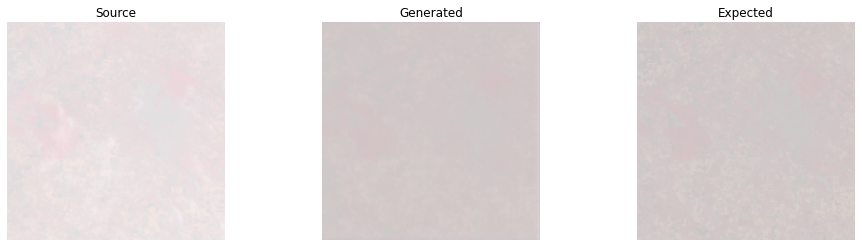

In [ ]:
X1,X2=src_data,tar_data
print('Loaded', X1.shape, X2.shape)
# load model
model = load_model('model_002000.h5')

ix = randint(0, len(X1), 1)
src_image, tar_image =np.copy(src_data[ix]), np.copy(tar_data[ix])

#Generate the image
gen_image = model.predict(src_image)
# plot all three images
plot_images(src_image, gen_image, tar_image)

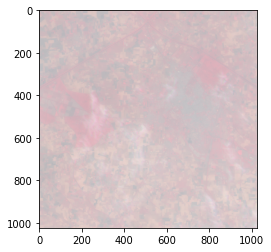

In [ ]:
plt.imshow(src_image[0])

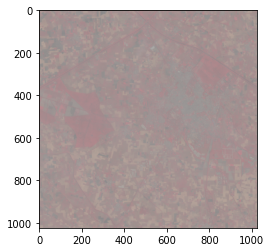

In [ ]:
plt.imshow(tar_image[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


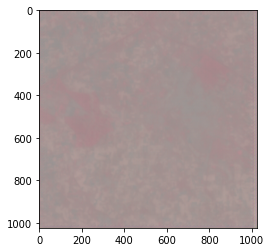

In [ ]:
plt.imshow(gen_image[0])

## Evaluation 

In [ ]:
from keras.models import load_model
from numpy import load, corrcoef
from numpy import vstack
from matplotlib import pyplot
from numpy.random import randint
import os
from math import log10, sqrt, ceil
import pandas as pd

#PSNR Metric Calculation 

def PSNR(target, generated):
  '''
  This function calculates the Peak Sound to Noise ratio for a target image with reference to a source image
  args --> source image, target image
  NOTE: source_image.shape MUST EQUAL target_image.shape
  '''
  mse = np.mean((target - generated)**2)
  if (mse == 0):
    #This means there is no difference between the pixel values/DN values of the source
    #image and the target image. Hence 100% sound and 0% noise
    return 100
  
  max_pixel = 1
  psnr = 20 * log10(max_pixel / sqrt(mse))
  return psnr

Using TensorFlow backend.


In [ ]:
#random pixel locations on the image
locations = pd.read_csv(ROOT_PATH + '/random_sampling.csv')
x = locations['Y']
y = locations['X']

In [ ]:
#function to get correlation 

def getPearsonCorrelation(epoch, gen, tar, training=True):
  '''
  This function calculates the Person Correlation between the generated and the target image
  '''
  if training:
    epochs.append(epoch)
  
  #Band-wise Pearson Correlation
  gen_values_nir = []
  tar_values_nir = []

  gen_values_red = []
  tar_values_red = []

  gen_values_green = []
  tar_values_green = []

  # extract values as per random sampling pixel locations
  for i,j in zip(x,y):
    gen_values_nir.append(gen[i][j][0])
    gen_values_red.append(gen[i][j][1])
    gen_values_green.append(gen[i][j][2])

    tar_values_nir.append(tar[i][j][0])
    tar_values_red.append(tar[i][j][1])
    tar_values_green.append(tar[i][j][2])
  
  # calculate person correlation for each band

  if training:
    correlation_nir.append(corrcoef(gen_values_nir, tar_values_nir)[1,0])
    correlation_red.append(corrcoef(gen_values_red, tar_values_red)[1,0])
    correlation_green.append(corrcoef(gen_values_green, tar_values_green)[1,0])
  else:
    correlation_nir_v.append(corrcoef(gen_values_nir, tar_values_nir)[1,0])
    correlation_red_v.append(corrcoef(gen_values_red, tar_values_red)[1,0])
    correlation_green_v.append(corrcoef(gen_values_green, tar_values_green)[1,0])

In [ ]:
from skimage.metrics import structural_similarity

#load source and target dataset
X1,X2=src_data,tar_data

#select source and target images at random
ix = randint(0, len(X1), 1)
src_img, tar_img =np.copy(src_data[2]), np.copy(tar_data[2])

psnr_metric_training = []
psnr_metric_validation = []
ssim_training = []
ssim_validation = []

# step is the size of the training/testing set divided by 10
step = len(src_data)/10

epochs = []
#training
correlation_nir = []
correlation_red = []
correlation_green = []

#read validation image
test_img = np.load(ROOT_PATH + '/perlin_octv8_neg_90_.npy')

#validation 
correlation_nir_v = []
correlation_red_v = []
correlation_green_v = []

for i in range(1,18):
  #print('Tar img: ',tar_img.shape)
  #print('Src img: ', src_img.shape)
  #print('Test img: ', test_img.shape)
  model = load_model('model_%06d.h5' % ceil((i*step*100)))
  gen_img = model.predict(src_img.reshape(-1,1024,1024,3))
  val_img = model.predict(test_img.reshape(-1,1024,1024,3))
  #print('Val img: ', val_img.shape)
  #print('Gen Img: ', gen_img.shape)
  psnr_t = PSNR(tar_img, gen_img)
  psnr_metric_training.append(psnr_t)
  psnr_v = PSNR(tar_img, val_img)
  psnr_metric_validation.append(psnr_v)
  ssim_t = structural_similarity(tar_img, gen_img[0,:,:,:], multichannel=True)
  ssim_training.append(ssim_t)
  ssim_v = structural_similarity(tar_img, val_img[0,:,:,:], multichannel=True)
  ssim_validation.append(ssim_v)
  getPearsonCorrelation(ceil(i*step*100), gen_img[0,:,:,:], tar_img)
  getPearsonCorrelation(ceil(i*step*100), val_img[0,:,:,:], tar_img, training=False)
  print('model_%06d.h5' % ceil((i*step*100)) ,ceil(i*step*100), psnr_t, psnr_v, ssim_t, ssim_v)
print('*****************************************************')
print()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


model_000100.h5 100 8.428116183408772 8.244584331994428 0.12281810140874212 0.12022261875461844
model_000200.h5 200 16.55112454541859 15.309477684380287 0.45493759586001065 0.43305178485624113
model_000300.h5 300 30.776547073497774 24.54769479723209 0.8820904094613882 0.8002735400995363
model_000400.h5 400 32.467772594068556 26.21404839030488 0.9272213718503405 0.8599918971804449
model_000500.h5 500 32.50592155317447 27.719906510028878 0.9355571469465965 0.8838601439691054
model_000600.h5 600 33.00282215035415 27.06036195431851 0.9377580287414805 0.8908196636277946
model_000700.h5 700 32.869750981843005 27.76691021624634 0.9342607702936648 0.8924074003941813
model_000800.h5 800 33.05695104274398 27.92563858158559 0.9396341950538796 0.8968900451251538
model_000900.h5 900 32.79122220238146 27.502957101868006 0.9343543529095005 0.8826278952248985
model_001000.h5 1000 32.93515772644777 27.297178208148928 0.9318222623252339 0.8704340844070688
model_001100.h5 1100 32.45214753637909 29.754503

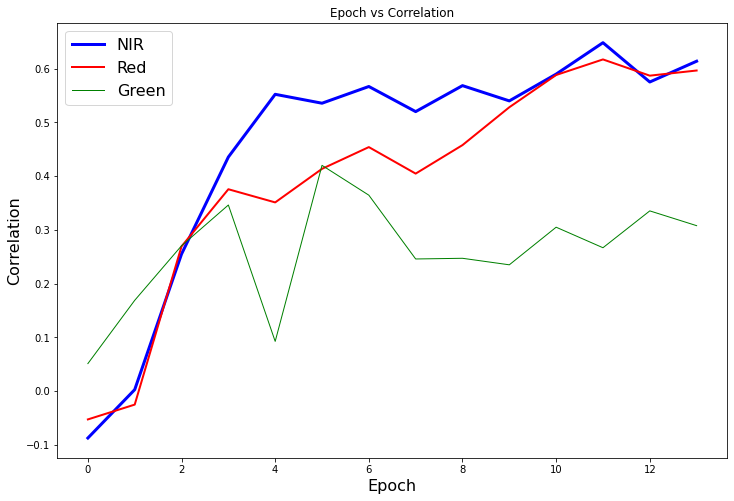

In [ ]:
# plotting epoch vs correlation

plt.figure(figsize=(12,8))
plt.title('Epoch vs Correlation')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Correlation', fontsize=16)
plt.plot(correlation_nir, 'b-', lw=3, label='NIR')
plt.plot(correlation_red, 'r-', lw=2, label='Red')
plt.plot(correlation_green, 'g-', lw=1, label='Green')
plt.legend(prop={'size':16})

# saving the plot
plt.savefig(ROOT_PATH + '/epoch_vs_corr.png')

In [ ]:
epochs

[100,
 100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400]

In [ ]:
df = pd.DataFrame(columns=['Epoch', 'NIR_PC_train', 'NIR_PC_val', 'Red_PC_train', 'Red_PC_val', 'Green_PC_train', 'Green_PC_val', 'PSNR_train', 'PSNR_val', 'SSIM_train', 'SSIM_val'])

# populating the df and saving csv
#epochs
df['Epoch'] = epochs

#PC
df['NIR_PC_train'] = correlation_nir
df['NIR_PC_val'] = correlation_nir_v
df['Red_PC_train'] = correlation_red
df['Red_PC_val'] = correlation_red_v
df['Green_PC_train'] = correlation_green
df['Green_PC_val'] = correlation_green_v

#PSNR
df['PSNR_train'] = psnr_metric_training
df['PSNR_val'] = psnr_metric_validation

#SSIM
df['SSIM_train'] = ssim_training
df['SSIM_val'] = ssim_validation

# saving the dataframe
df.to_csv(ROOT_PATH + '/eval_.csv')

In [ ]:
!pip install scikit-image

In [ ]:
from skimage.metrics import structural_similarity
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
tar = np.load(ROOT_PATH + '/target.npy')
gen = np.load(ROOT_PATH + '/generated.npy')

In [ ]:
val = np.load(ROOT_PATH + '/perlin_octv8_neg_90_.npy')

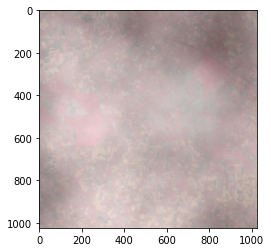

In [ ]:
plt.imshow(val)

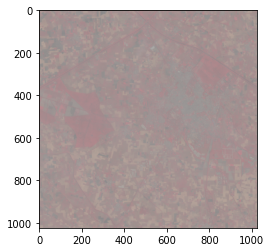

In [ ]:
plt.imshow(tar_data[2])

In [ ]:
structural_similarity(gen,tar, multichannel=True)

/usr/local/lib/python3.6/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


0.631602266584288

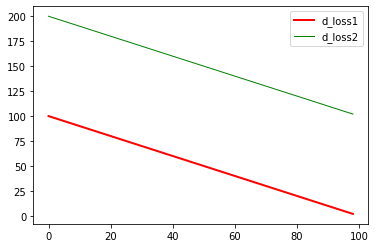

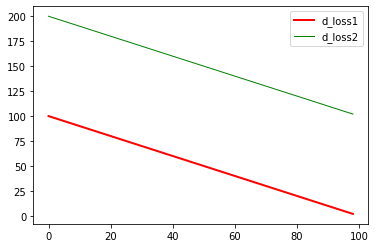

In [ ]:
 from IPython import display
 from matplotlib import pyplot as plt

plt.ion()
fig = plt.figure()

epoch = [i for i in range(100)]
d_loss1 = [(100-i) for i in range(100)]
d_loss2 = [(200-i) for i in range(100)]

for i in range(1,len(epoch)):
  plt.clf()
  plt.plot(d_loss1[:i], 'r-', lw=2, label='d_loss1')
  plt.plot(d_loss2[:i], 'g-', lw=1, label='d_loss2')
  plt.legend()
  display.clear_output(wait=True)
  display.display(plt.gcf())
  # fig = plt.figure()
  # ax1 = fig.add_subplot(1,1,1)
  # ax1.clear()
  # ax1.plot(epoch[:i])
  # ax1.plot(d_loss1[:i])
  # ax1.plot(d_loss2[:i])
  # plt.show()

In [ ]:
a = [i for i in range(10)]

for i in range(1,len(a)):
  print(a[:i])

[0]
[0, 1]
[0, 1, 2]
[0, 1, 2, 3]
[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6]
[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [ ]:
a = []
while (1):
  a.append('1')

In [ ]:
from google.colab import files

In [ ]:
files.download('./model_001700.h5')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 43804, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [ ]:
!sudo cp model_001700.h5 'gdrive'

cp: cannot create regular file 'gdrive/model_001700.h5': Operation not supported


In [ ]:
!pwd

/content


In [ ]:
"""Perlin noise implementation."""
# Licensed under ISC
from itertools import product
import math
import random


def smoothstep(t):
    """Smooth curve with a zero derivative at 0 and 1, making it useful for
    interpolating.
    """
    return t * t * (3. - 2. * t)


def lerp(t, a, b):
    """Linear interpolation between a and b, given a fraction t."""
    return a + t * (b - a)


class PerlinNoiseFactory(object):
    """Callable that produces Perlin noise for an arbitrary point in an
    arbitrary number of dimensions.  The underlying grid is aligned with the
    integers.
    There is no limit to the coordinates used; new gradients are generated on
    the fly as necessary.
    """

    def __init__(self, dimension, octaves=1, tile=(), unbias=False):
        """Create a new Perlin noise factory in the given number of dimensions,
        which should be an integer and at least 1.
        More octaves create a foggier and more-detailed noise pattern.  More
        than 4 octaves is rather excessive.
        ``tile`` can be used to make a seamlessly tiling pattern.  For example:
            pnf = PerlinNoiseFactory(2, tile=(0, 3))
        This will produce noise that tiles every 3 units vertically, but never
        tiles horizontally.
        If ``unbias`` is true, the smoothstep function will be applied to the
        output before returning it, to counteract some of Perlin noise's
        significant bias towards the center of its output range.
        """
        self.dimension = dimension
        self.octaves = octaves
        self.tile = tile + (0,) * dimension
        self.unbias = unbias

        # For n dimensions, the range of Perlin noise is ±sqrt(n)/2; multiply
        # by this to scale to ±1
        self.scale_factor = 2 * dimension ** -0.5

        self.gradient = {}

    def _generate_gradient(self):
        # Generate a random unit vector at each grid point -- this is the
        # "gradient" vector, in that the grid tile slopes towards it

        # 1 dimension is special, since the only unit vector is trivial;
        # instead, use a slope between -1 and 1
        if self.dimension == 1:
            return (random.uniform(-1, 1),)

        # Generate a random point on the surface of the unit n-hypersphere;
        # this is the same as a random unit vector in n dimensions.  Thanks
        # to: http://mathworld.wolfram.com/SpherePointPicking.html
        # Pick n normal random variables with stddev 1
        random_point = [random.gauss(0, 1) for _ in range(self.dimension)]
        # Then scale the result to a unit vector
        scale = sum(n * n for n in random_point) ** -0.5
        return tuple(coord * scale for coord in random_point)

    def get_plain_noise(self, *point):
        """Get plain noise for a single point, without taking into account
        either octaves or tiling.
        """
        if len(point) != self.dimension:
            raise ValueError("Expected {} values, got {}".format(
                self.dimension, len(point)))

        # Build a list of the (min, max) bounds in each dimension
        grid_coords = []
        for coord in point:
            min_coord = math.floor(coord)
            max_coord = min_coord + 1
            grid_coords.append((min_coord, max_coord))

        # Compute the dot product of each gradient vector and the point's
        # distance from the corresponding grid point.  This gives you each
        # gradient's "influence" on the chosen point.
        dots = []
        for grid_point in product(*grid_coords):
            if grid_point not in self.gradient:
                self.gradient[grid_point] = self._generate_gradient()
            gradient = self.gradient[grid_point]

            dot = 0
            for i in range(self.dimension):
                dot += gradient[i] * (point[i] - grid_point[i])
            dots.append(dot)

        # Interpolate all those dot products together.  The interpolation is
        # done with smoothstep to smooth out the slope as you pass from one
        # grid cell into the next.
        # Due to the way product() works, dot products are ordered such that
        # the last dimension alternates: (..., min), (..., max), etc.  So we
        # can interpolate adjacent pairs to "collapse" that last dimension.  Then
        # the results will alternate in their second-to-last dimension, and so
        # forth, until we only have a single value left.
        dim = self.dimension
        while len(dots) > 1:
            dim -= 1
            s = smoothstep(point[dim] - grid_coords[dim][0])

            next_dots = []
            while dots:
                next_dots.append(lerp(s, dots.pop(0), dots.pop(0)))

            dots = next_dots

        return dots[0] * self.scale_factor

    def __call__(self, *point):
        """Get the value of this Perlin noise function at the given point.  The
        number of values given should match the number of dimensions.
        """
        ret = 0
        for o in range(self.octaves):
            o2 = 1 << o
            new_point = []
            for i, coord in enumerate(point):
                coord *= o2
                if self.tile[i]:
                    coord %= self.tile[i] * o2
                new_point.append(coord)
            ret += self.get_plain_noise(*new_point) / o2

        # Need to scale n back down since adding all those extra octaves has
        # probably expanded it beyond ±1
        # 1 octave: ±1
        # 2 octaves: ±1½
        # 3 octaves: ±1¾
        ret /= 2 - 2 ** (1 - self.octaves)

        if self.unbias:
            # The output of the plain Perlin noise algorithm has a fairly
            # strong bias towards the center due to the central limit theorem
            # -- in fact the top and bottom 1/8 virtually never happen.  That's
            # a quarter of our entire output range!  If only we had a function
            # in [0..1] that could introduce a bias towards the endpoints...
            r = (ret + 1) / 2
            # Doing it this many times is a completely made-up heuristic.
            for _ in range(int(self.octaves / 2 + 0.5)):
                r = smoothstep(r)
            ret = r * 2 - 1

        return ret

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

pnf = PerlinNoiseFactory(3)

# target = np.copy(tar_data[0])
original = np.load(ROOT_PATH + '/target.npy')
target = np.copy(original)

R = target[:,:,0]
G = target[:,:,1]
B = target[:,:,2]

for i in range(1024):
  for j in range(1024):
    R[i][j] += pnf(i/1024, j/1024, 1)
    G[i][j] += pnf(i/1024, j/1024, 1)
    B[i][j] += pnf(i/1024, j/1024, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


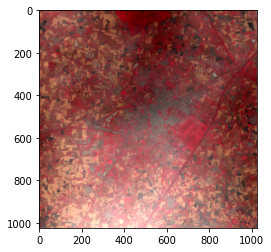

In [ ]:
# R = tar_data[0][:,:,0]
# G = tar_data[0][:,:,1]
# B = tar_data[0][:,:,2]
xyz = np.dstack((R,G,B))
plt.imshow(target)

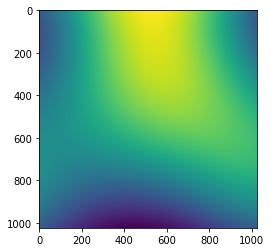

In [ ]:
plt.imshow(noise)

In [ ]:
import PIL.Image
from matplotlib import pyplot as plt

size = 1024
res = 1024
frames = 103
frameres = 26
space_range = size//res
frame_range = frames//frameres

pnf = PerlinNoiseFactory(3, octaves=8, tile=(space_range, space_range, frame_range))

# target = np.copy(tar_data[0])

# R = target[:,:,0]
# G = target[:,:,1]
# B = target[:,:,2]

for t in range(frames):
    # img = PIL.Image.new('L', (size, size))
    noise = [[0 for i in range(1024)] for j in range(1024)]
    for x in range(size):
        for y in range(size):
            n = pnf(x/res, y/res, t/frameres)
            # img.putpixel((x, y), int((n + 1) / 2 * 255 + 0.5))
            noise[x][y] = n
            R[x][y] += n
            G[x][y] += n
            B[x][y] += n


    
    # plt.imshow(noise)
    break
    # img.save("noiseframe{:03d}.png".format(t))
    # print(t)

NameError: ignored

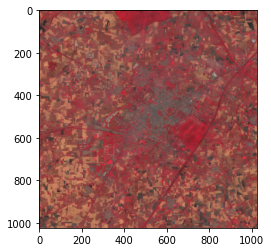

In [ ]:
plt.imshow(original)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


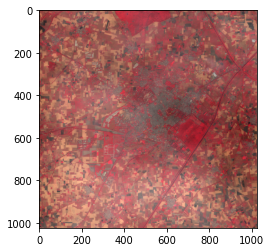

In [ ]:
plt.imshow(target)

In [ ]:
t = np.dstack((R,G,B))
t.shape

(1024, 1024, 3)

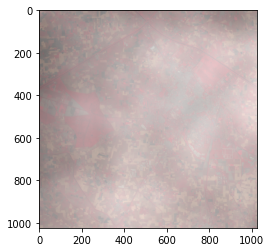

In [ ]:
plt.imshow(t)

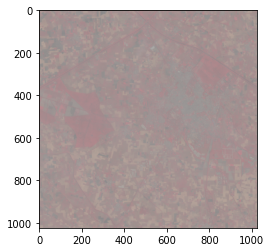

In [ ]:
plt.imshow(tar_data[0])

In [ ]:
np.save(ROOT_PATH + '/new_perlin_light', target)

In [ ]:
test = load(ROOT_PATH + '/data/pure_neg_90_.npy')

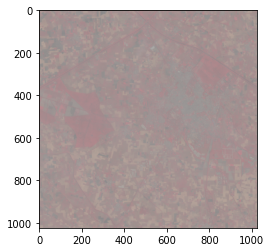

In [ ]:
plt.imshow(test)

In [ ]:
%tensorflow_version 

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


In [ ]:
import keras
keras.__version__

'2.3.1'